# Khám phá mối quan hệ trong dữ liệu

## Import các thư viện cần thiết

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
#from wordcloud import WordCloud
#from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

## Đọc dữ liệu từ file csv vào dataframe


In [3]:
data = pd.read_csv("../datasets/data_preprocess.csv", index_col = 0)
data.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


## Đặt vấn đề: Nhà sản xuất phim nên công chiếu phim mình vào thời gian nào để đạt doanh thu cao?

### 1. Tìm hiểu mối quan hệ giữa các biến

Trước khi đi vào tìm hiểu sâu hơn về mối quan hệ giữa các biến, ta vẽ biểu đồ corvariance Heatmap để chọn các biến phù hợp.

/tmp/ipykernel_55288/3216263625.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


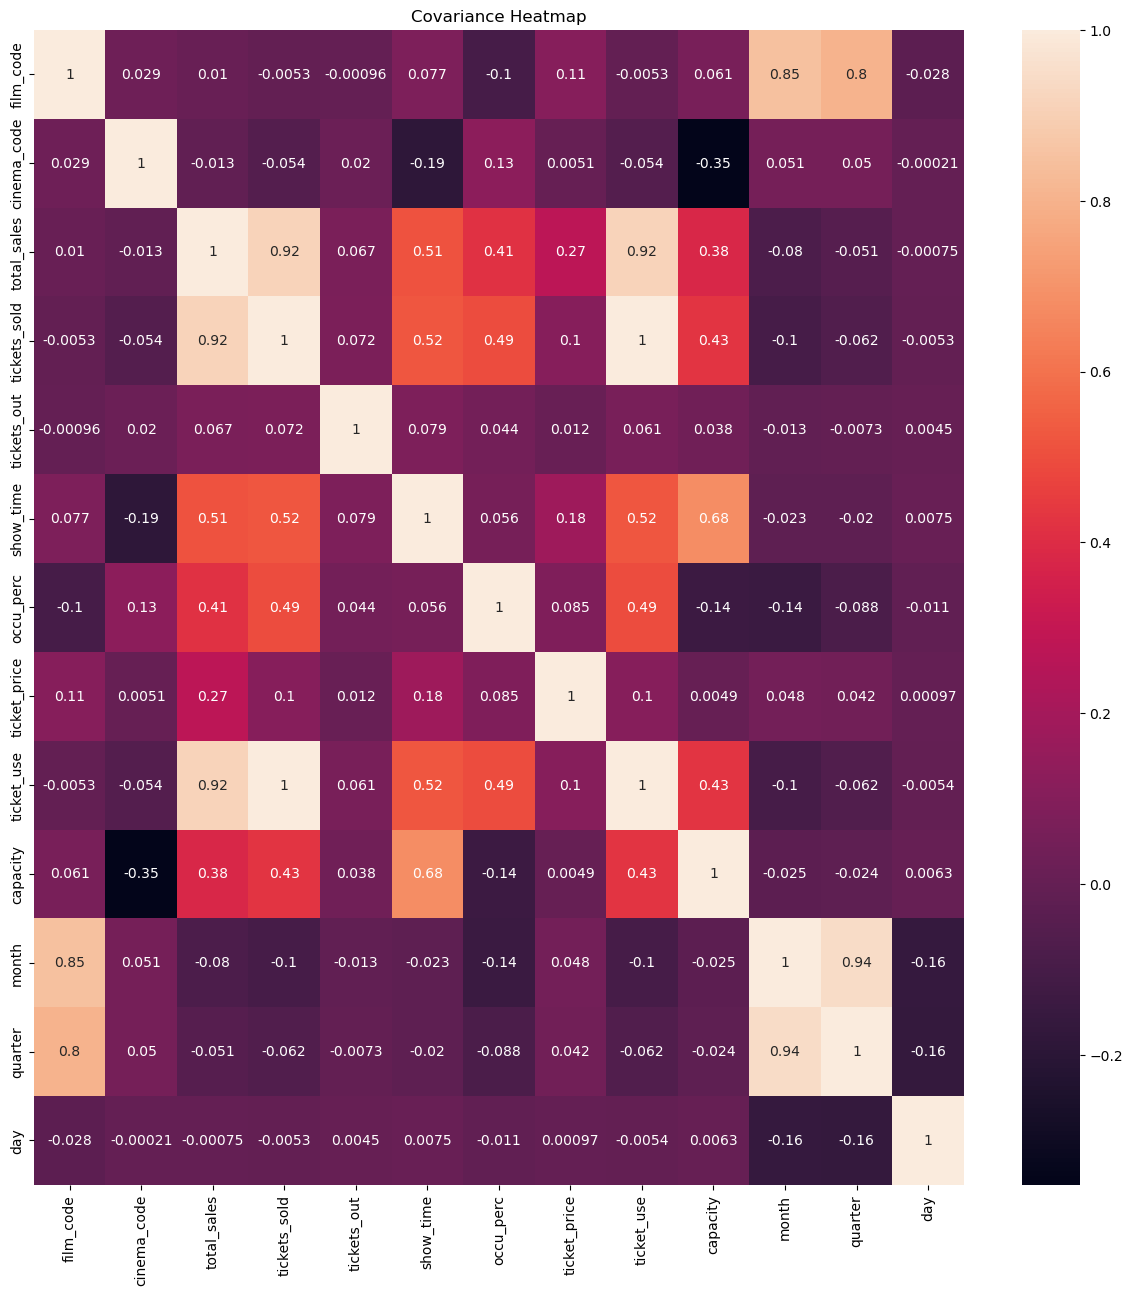

In [4]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

sns.heatmap(corr_matrix, annot=True, ax = ax)
plt.title("Covariance Heatmap")
plt.show()

Nhận xét:
- Ta quan tâm nhiều đến doanh thu và sự thay đổi cuả nó theo thời gian. Theo biểu đồ trên, doanh thu ảnh hưởng nhiều bởi: Tickets_sold, Tickets_use, show_time, capacity, occu_perc.
- Theo sự quan sát dữ liệu nhận thấy tickets_use = tickets_sold - tickets_out. Tuy nhiên theo biểu đồ thì tickets_out không ảnh hưởng nhiều nên giữa 2 biến tickets_out và tickets_use ta chỉ quan tâm 1 (chọn tickets_sold)

### 2. Số lượng bộ phim được chiếu theo quý và theo tháng

**Trường dữ liệu:**
- `month` và `film_code`
- `quarter` và `film_code` 

**Lý do chọn biểu đồ:**
- Biểu đồ cột có thể dễ dàng thấy và so sánh được giữa các tháng trong năm

**Lý do chọn màu sắc:**
- Mặc dù sử dụng label đã có thể trực quan nhưng sử dụng màu nữa sẽ dễ phân biệt các mùa hơn. Hơn nữa nếu biểu đồ tháng sử dụng màu của biểu đồ quý sẽ giúp nhìn dễ hơn tháng đó thuộc quý nào.

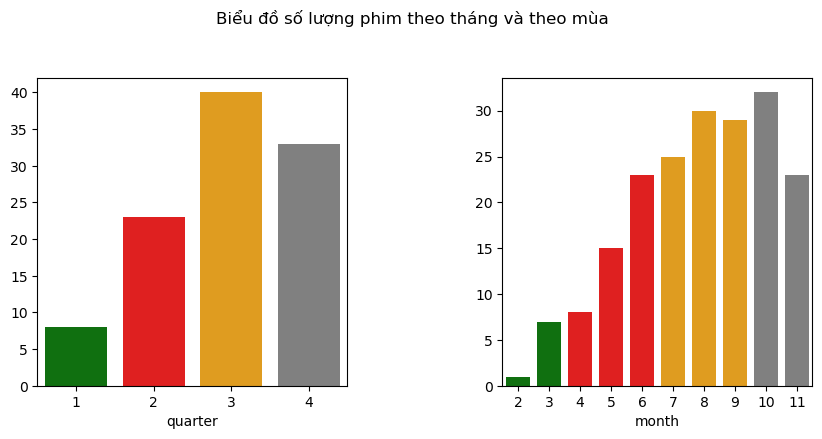

In [18]:
#Đếm số bộ phim của mỗi quý, tháng. Vì mỗi phim có chiếu trên nhiều rạp và trên nhiều ngày 
#nên dùng nunique
season_color = ['green', 'red', 'orange', 'gray']
month_color = ['green', 'green', 'red','red', 'red', 'orange','orange', 'orange', 'gray', 'gray', 'gray']

'''
Green: Mùa xuân, cây hoa lá trổ bông.
Red: Mùa hè, rộn ràng, náo nhiệt, năng động.
Orange: Mùa thu, sự mất mát, cây cối rụng lá.
Gray: Mùa đông, u ám, lạnh lẽo, yên tĩnh.
'''


count_quarter = data.groupby('quarter')['film_code'].nunique()
count_month = data.groupby('month')['film_code'].nunique()

figure, axis = plt.subplots(1, 2, figsize=(10, 4))

plt.subplots_adjust(wspace=0.5)

figure.suptitle('Biểu đồ số lượng phim theo tháng và theo mùa', y = 1.05)


sns.barplot(x = count_quarter.index, y = count_quarter.values, ax = axis[0], palette = season_color)
sns.barplot(x = count_month.index, y = count_month.values, ax =axis[1], palette = month_color)
plt.show()

Nhận xét:
- Vì dữ liệu gốc chỉ có từ tháng 2 - 11 nên số lượng phi, quý 1 hơi ít. Tuy nhiên khi nhìn vào biểu đồ tháng thì quả thật tháng 2 và 3 có số lượng phim ít hơn nhiều so với các tháng khác.
- Số lượng phim chiếu trên các rạp tăng dần từ quý 1 đến đầu quý 4 (tháng 2 đến tháng 10), sau đó giảm dần.
- Quý 3 (mùa thu) là thời điểm có nhiều phim ra mắt nhất. 

Như vậy, mùa thu và đầu mùa đông là thời điểm có nhiều phim được chiếu rạp nhất, vậy liệu đây chính là thời điểm tốt nhất để các nhà phát hành phim phát hành phim của mình?

### 3. Tổng doanh thu và tổng số vé trung bình  của các phim được chiếu theo  quý.

**Trường dữ liệu:**
- `quarter` và `ticket_sales` 
- `quarter` và `ticket_sold`


**Lý do chọn biểu đồ:**
  - Biểu đồ cột có thể dễ dàng thấy và so sánh được giữa các quý trong năm
  
**Lý do chọn màu sắc:** 
- Mặc dù sử dụng label đã có thể trực quan nhưng sử dụng màu nữa sẽ dễ phân biệt các mùa hơn. Hơn nữa nếu biểu đồ tháng sử dụng màu của biểu đồ quý sẽ giúp nhìn dễ hơn tháng đó thuộc quý nào.

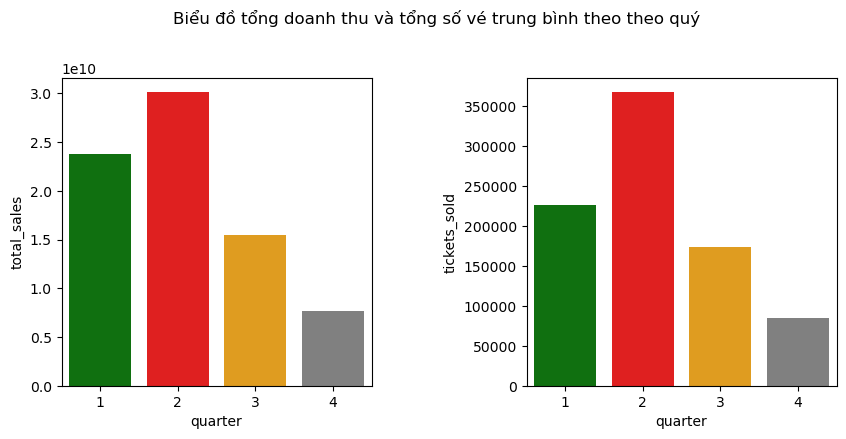

In [29]:
#Lọc dữ liệu
df_quater = data.groupby(data["quarter"])[["total_sales", "tickets_sold"]].sum()
df_quater = df_quater.div(count_quarter, axis = 0)


figure, axis = plt.subplots(1, 2, figsize=(10, 4))

plt.subplots_adjust(wspace=0.5)


#Sử dụng seaborn để vẽ các biểu đồ cột

figure.suptitle('Biểu đồ tổng doanh thu và tổng số vé trung bình theo theo quý', y = 1.05)

sns.barplot(df_quater, x = df_quater.index, y = df_quater["total_sales"], ax = axis[0], palette = season_color)
sns.barplot(df_quater, x = df_quater.index, y = df_quater["tickets_sold"], ax =axis[1], palette = season_color)

plt.show()

Nhận xét:
- Mặc dù rất nhiều phim đều được chiếu ở mùa thu và đầu mùa đông, tuy nhiên doanh thu trung bình cao nhất là các bộ phim được chiếu ở mùa hè. Bên cạnh đó mùa xuân có rất ít bộ phim nhưng doanh thu trung bình cũng rất cao, hơn hẳn mùa thu và mùa đông.
- Như đã biết, số vé bán được là yếu tố ảnh hưởng rất lớn đến doanh thu. Ở biểu đồ trên cũng thấy được rằng số vé bán được ở mùa xuân cao hơn cả mùa thu và mùa đông, mặc dù số phim ít hơn rất nhiều. 
- Giải thích ban đầu cho những điều trên đó chính là do mùa thu và mùa đông có quá nhiều phim nên cạnh tranh lẫn nhau, dẫn đến doanh thu và số lượng vé giảm xuống. Bên cạnh đó, những con số trên biểu đồ là trung bình doanh thu và trung bình số lượng vé của mỗi bộ phim, việc có nhiều bộ phim sẽ dẫn đến nhiều bộ phim kết quả thấp sẽ kéo kết quả trung bình xuống.

Như vậy, mùa hè và mùa xuân là có doanh thu và số lượng vé cao hơn nhiều, vậy tại sao người ta vẫn đổ xô việc phát hành phim vào mùa thu và đông?

### 4. Tổng doanh thu và tổng số vé trung bình của các phim được chiếu theo tháng

**Trường dữ liệu:**
- `month` và `ticket_sales` 
- `month` và `ticket_sold`


**Lý do chọn biểu đồ:**
  - Biểu đồ cột có thể dễ dàng thấy và so sánh được giữa các tháng trong năm
  
**Lý do chọn màu sắc:** 
- Mặc dù sử dụng label đã có thể trực quan nhưng sử dụng màu nữa sẽ dễ phân biệt các mùa hơn. Hơn nữa nếu biểu đồ tháng sử dụng màu của biểu đồ quý sẽ giúp nhìn dễ hơn tháng đó thuộc quý nào.

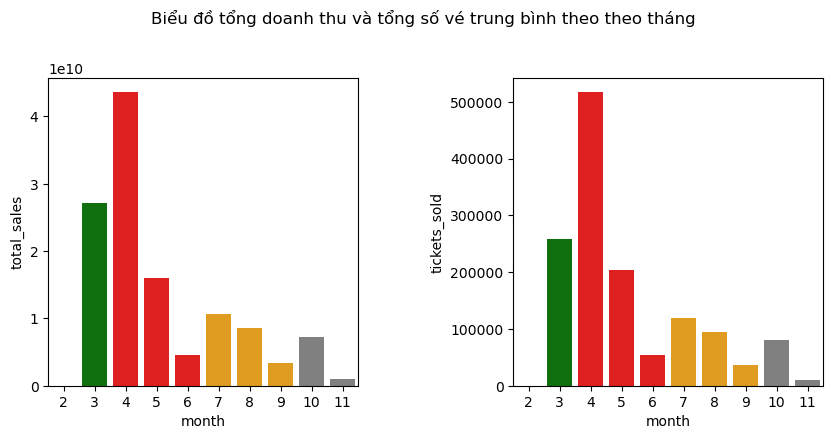

In [28]:
#Lọc dữ liệu
df_month = data.groupby(data["month"])[["total_sales", "tickets_sold"]].sum()
df_month = df_month.div(count_month, axis = 0)


figure, axis = plt.subplots(1, 2, figsize=(10, 4))

plt.subplots_adjust(wspace=0.5)


#Sử dụng seaborn để vẽ các biểu đồ cột

figure.suptitle('Biểu đồ tổng doanh thu và tổng số vé trung bình theo theo tháng', y = 1.05)

sns.barplot(df_month, x = df_month.index, y = df_month["total_sales"], ax = axis[0], palette = month_color)
sns.barplot(df_month, x = df_month.index, y = df_month["tickets_sold"], ax =axis[1], palette = month_color)

plt.show()

Nhận xét:
- Bộ dữ liệu thu thập từ ngày 21/2-04/11 nên có thể hiểu về giá trị doanh thu và số vé bán được của tháng đầu và cuối.
- Tháng 4 có số lượt cao vượt bậc là do tháng đó công chiếu bộ phim "Avenger: Infinity War", đây là bộ phim có doanh thu kỷ lục thế giới (2 tỷ USD), nên kéo theo doanh thu của tháng đó cao, ngoài ra còn có các bộ phim khác cũng rất cao, chủ yếu về chủ đề siêu anh hùng. 
- Theo thông tin từ internet, mỗi tháng sẽ những chủ đề phim khác nhau gắn với những chủ đề tháng đó. Ví dụ những những bộ phim tình cảm có thể thường chiếu vào tháng 2 (có ngày valentine), phim kinh dị, hài thì chiếu vào tháng 10 (có ngày halloween), các bộ phim siêu anh hùng thì thường chiếu các tháng mùa hè (do fan chủ yếu học sinh, nghỉ hè nghỉ lễ mới xem nhiều).
- Những bộ phim siêu anh hùng thường có kinh phí rất cao, cần nhiều đầu tư, và đến hiện nay thì có marvel và DC là hai hãng nổi bật, rất đông fan. Nên có thể nói là số lượng phim siêu anh hùng sẽ ít. Điều này giải thích vì sao tháng 3, 4 ,5 lại có ít phim nhưng doanh thu và số vé bán rất cao.
- Các bộ phim dễ làm hơn và có số lượng cao thì thường có chủ đề như hài hước, tình cảm, phiêu lưu, các bộ phim này sẽ chiếu vào mùa thu và mùa đông (từ tháng 7-12). Vì vậy thời điểm này số phim ngoài rạp sẽ cao, và doanh thu trung bình của mỗi phim sẽ thấp hơn so với các tháng trước đó.